In [33]:
import os
import csv
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
import matplotlib.pyplot as plt
from darts.metrics import mape, mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, BlockRNNModel, NBEATSModel, XGBModel, LightGBMModel

ORIGINAL_DATA_PATH = os.getcwd() + '/../data/Fundamental+Technical Data/STOCK_DATA/'
DATA_PATH = os.getcwd() + '/../data/Fundamental+Technical Data/STOCK_DATA_WEEKLY/'
LDA_NEWS_PATH = os.getcwd() + '/../data/Online Data/LDA News/News.csv'
LDA_TWITTER_PATH = os.getcwd() + '/../data/Online Data/LDA Twitter/Twitter.csv'
GDELT_V1_PATH = os.getcwd() + '/../data/Online Data/GDELT V1/gdelt_v1.csv'
GDELT_V2_PATH = os.getcwd() + '/../data/Online Data/GDELT V2/gdelt_v2.csv'
ID_PATH = os.getcwd() + '/../data/Fundamental+Technical Data/ID_Name.csv'
RESULT_PATH = os.getcwd() + '/../result/'
PARAMETER_PATH = os.getcwd() + '/../model/'
FOCUS_COMPONENT = 'Close'
RETAIN_COMPONENTS = ["Open", "High", "Low", "PE", "PBV", "T_EPS", "FSCORE", "Vol",
                           "Buy Vol", "Sell Vol", "ATO/ATC", "EMA25", "EMA50", "EMA200", "MACD", "RSI"]
TRAINING_SIZE = 139
VALIDATE_SIZE = 35
TEST_SIZE = 35
PREDICT_SIZE = 1
STOCK_LIST = ["ADVANC", "BANPU", "BH", "BTS", "CBG", "CPALL", "CPF", "INTUCH", "IVL", "KBANK", "LH", "PTT", "PTTEP", "PTTGC", "SCB", "SCC", "TISCO", "TU", "WHA"]

def load_data(stock_name):
    stock_data = pd.read_csv(os.path.join(DATA_PATH, (stock_name + ".csv")))
    id_name_map = pd.read_csv(ID_PATH)
    stock_id = id_name_map.loc[id_name_map['Stock_Name'].str.strip() == stock_name, 'Stock_ID'].iloc[0]
    industry_name = id_name_map.loc[id_name_map['Stock_Name'].str.strip() == stock_name, 'Industry_Name'].iloc[0]
    lda_news_df = pd.read_csv(LDA_NEWS_PATH)
    prefix = "news"
    lda_news_df.columns =  [f"{prefix}_{col}" if col != 'Date' else col for col in lda_news_df.columns]
    lda_twitter_df = pd.read_csv(LDA_TWITTER_PATH)
    prefix = "twitter"
    lda_twitter_df.columns =  [f"{prefix}_{col}" if col != 'Date' else col for col in lda_twitter_df.columns]
    GDELTv1 = pd.read_csv(GDELT_V1_PATH)
    prefix = "gdeltv1"
    GDELTv1.columns =  [f"{prefix}_{col}" if col != 'Date' else col for col in GDELTv1.columns]
    GDELTv2 = pd.read_csv(GDELT_V2_PATH)
    prefix = "gdeltv2"
    GDELTv2.columns =  [f"{prefix}_{col}" if col != 'Date' else col for col in GDELTv2.columns]
    data_df = stock_data.copy()
    return stock_data, stock_id, data_df, lda_news_df, lda_twitter_df, GDELTv1, GDELTv2

def limit_column_name_length(df, max_length):
    truncated_columns = {col: col[:max_length] for col in df.columns}
    df.rename(columns=truncated_columns, inplace=True)
    return df

def preprocess_online_data(data_df, online_data_df):
    if 'Date' in data_df.columns:
        data_df['Date'] = pd.to_datetime(data_df['Date'])
        data_df.set_index('Date', inplace=True)

    online_data_df['Date'] = pd.to_datetime(online_data_df['Date'])
    online_data_df.set_index('Date', inplace=True)
    
    # Remove news data after the last date in data_df
    last_data_date = data_df.index.max()
    online_data_df = online_data_df[online_data_df.index <= last_data_date]
    
    summed_df = pd.DataFrame(index=data_df.index.unique()).sort_index()
    summed = online_data_df.reindex(summed_df.index, method='ffill').fillna(0)
    summed_df = pd.concat([summed_df, summed], axis=1)
    summed_df.reset_index(inplace=True)

    return summed_df

def preprocess_data(data, data_df,  lda_news_df, lda_twitter_df, GDELTv1, GDELTv2, split, features):
    data = data.dropna()
    serie = data[FOCUS_COMPONENT]
    past_covariate = data[RETAIN_COMPONENTS].apply(pd.to_numeric, errors='coerce').ffill().bfill()
    
    if 2 in features:
        updated_lda_news_df = preprocess_online_data(data_df, lda_news_df)
        past_covariate = past_covariate.join(updated_lda_news_df.reset_index(drop=True).drop(columns='Date'))

    if 3 in features:
        updated_lda_twitter_df = preprocess_online_data(data_df, lda_twitter_df)
        past_covariate = past_covariate.join(updated_lda_twitter_df.reset_index(drop=True).drop(columns='Date'))

    if 4 in features:
        updated_GDELTv1 = preprocess_online_data(data_df, GDELTv1)
        past_covariate = past_covariate.join(updated_GDELTv1.reset_index(drop=True).drop(columns='Date'))

    if 5 in features:
        updated_GDELTv2 = preprocess_online_data(data_df, GDELTv2)
        past_covariate = past_covariate.join(updated_GDELTv2.reset_index(drop=True).drop(columns='Date'))

    past_covariate = limit_column_name_length(past_covariate, 10)

    serie_ts = TimeSeries.from_dataframe(serie.to_frame())
    past_cov_ts = TimeSeries.from_dataframe(past_covariate)
    scaler = StandardScaler()
    scaler_dataset = Scaler(scaler)
    scaled_serie_ts = scaler_dataset.fit_transform(serie_ts)
    if split == 0:
        training_scaled = scaled_serie_ts
    else:
        training_scaled = scaled_serie_ts[:-split]
        past_cov_ts = past_cov_ts[:-split]
    
    return training_scaled, past_cov_ts, scaler_dataset

def predict_next_n_days(model, training_scaled, past_cov_ts, scaler_dataset):
    model.fit(training_scaled, past_covariates=past_cov_ts, verbose=True)
    forecast = model.predict(PREDICT_SIZE, verbose=True)
    in_forecast = scaler_dataset.inverse_transform(forecast)
    return in_forecast

model = XGBModel(lags= 10,
                 lags_past_covariates= 2,
                 output_chunk_length= 1)
stock_data, stock_id, data_df, lda_news_df, lda_twitter_df, GDELTv1, GDELTv2 = load_data('ADVANC')
training_scaled, past_cov_ts, scaler_dataset = preprocess_data(stock_data, data_df, lda_news_df, lda_twitter_df, GDELTv1, GDELTv2, 70, [1,3,4])
predictions = predict_next_n_days(model, training_scaled, past_cov_ts, scaler_dataset)
round(predictions.values()[0][0],2)

218.3

In [12]:
from darts.explainability import SomeComponentBasedExplainer
explainer = SomeComponentBasedExplainer(model)
explain_results = explainer.explain()
output = explain_results.get_explanation(component="some_component")

ImportError: cannot import name 'SomeComponentBasedExplainer' from 'darts.explainability' (/data1-8tb-blk/sp2023stock/Insight-Wave/venv/lib/python3.10/site-packages/darts/explainability/__init__.py)

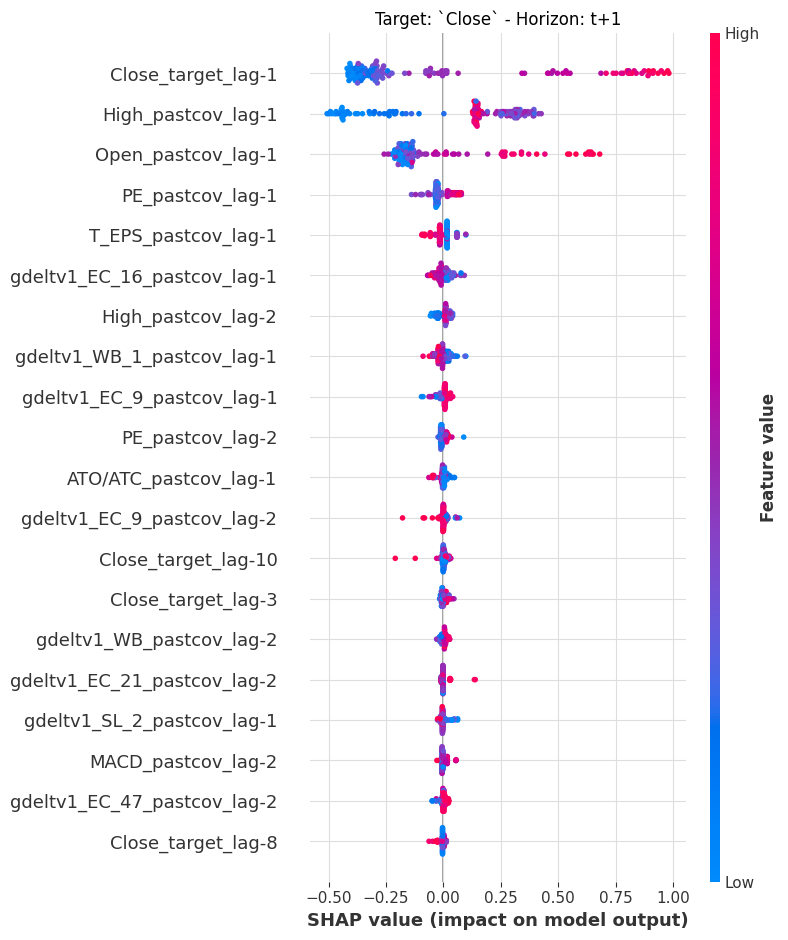

In [34]:
from darts.datasets import AirPassengersDataset
from darts.explainability.shap_explainer import ShapExplainer
from darts.models import LinearRegressionModel
# series = AirPassengersDataset().load()
# model = LinearRegressionModel(lags=12)
# model.fit(series[:-36])
shap_explain = ShapExplainer(model)
results = shap_explain.explain()
shap_explain.summary_plot()
shap_explain.force_plot_from_ts()

In [35]:
results

In [40]:
# To access feature importances, first get the booster from the trained model
booster = model.model.get_booster()

# Then, use get_score() method from the booster
# The importance_type can be 'weight', 'gain', or 'cover'
# 'weight' is the number of times a feature appears in a tree
# 'gain' is the average gain of splits which use the feature
# 'cover' is the average coverage of splits which use the feature
feature_importances = booster.get_score(importance_type='gain')

# Feature importances might need to be processed depending on your exact needs
# For visualization, you might want to sort them by importance
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Extracting feature names and their importances
features, importances = zip(*sorted_importances)


print(features)
print(importances)
# # Visualizing feature importances
# plt.figure(figsize=(10, 6))
# plt.bar(features, importances)
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.title('Feature Importances')
# plt.xticks(rotation=45)
# plt.show()

('f9', 'f257', 'f261', 'f256', 'f53', 'f438', 'f266', 'f444', 'f259', 'f279', 'f220', 'f475', 'f141', 'f200', 'f402', 'f181', 'f227', 'f260', 'f205', 'f8', 'f288', 'f48', 'f478', 'f258', 'f422', 'f431', 'f11', 'f51', 'f172', 'f463', 'f270', 'f192', 'f449', 'f423', 'f24', 'f207', 'f17', 'f199', 'f18', 'f185', 'f426', 'f7', 'f184', 'f32', 'f69', 'f26', 'f482', 'f424', 'f372', 'f201', 'f28', 'f139', 'f228', 'f437', 'f16', 'f485', 'f5', 'f466', 'f2', 'f0', 'f189', 'f237', 'f13', 'f339', 'f295', 'f187', 'f197', 'f27', 'f480', 'f234', 'f462', 'f10', 'f15', 'f477', 'f229', 'f4', 'f177', 'f81', 'f202', 'f176', 'f22', 'f305', 'f30', 'f198', 'f40', 'f263', 'f231', 'f474', 'f264', 'f265', 'f23', 'f268', 'f391', 'f42', 'f180', 'f6', 'f271', 'f153', 'f230', 'f12', 'f110', 'f1', 'f267', 'f210', 'f49', 'f212', 'f443', 'f476', 'f3', 'f458', 'f233', 'f433', 'f447', 'f19', 'f473', 'f272', 'f20', 'f439', 'f430', 'f55', 'f315', 'f215', 'f232', 'f193', 'f82', 'f393', 'f225', 'f320', 'f479', 'f21', 'f36', '